In [69]:
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger

import pickle
import re
from pathlib import Path

data_dir = Path(globals()['_dh'][0]).parent / 'data'
figure_dir = data_dir / 'figures'
figure_dir.mkdir(exist_ok=True)

plt.style.use('seaborn-bright')
plt.set_cmap('plasma')

<Figure size 432x288 with 0 Axes>

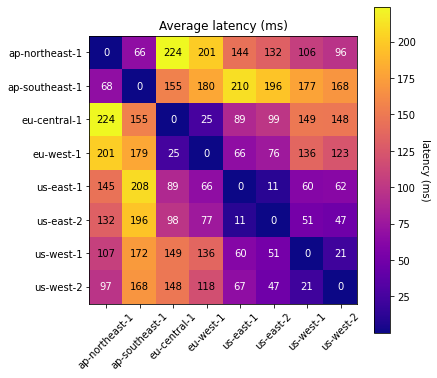

In [70]:
def parse_ping_result(string):
    """make regex with named groups"""
    regex = r'rtt min/avg/max/mdev = (?P<min>\d+\.\d+)/(?P<avg>\d+\.\d+)/(?P<max>\d+\.\d+)/(?P<mdev>\d+\.\d+) ms'
    m = re.search(regex, string)
    return dict(min=float(m.group('min')), avg=float(m.group('avg')), max=float(m.group('max')), mdev=float(m.group('mdev')))

with (data_dir / "latency_pairs.pickle").open('rb') as f:
    latency_pairs = pickle.load(f)

regions = list(sorted(list(set([x for x, y in latency_pairs.keys()] + [y for x, y in latency_pairs.keys()]))))
min_latencies = np.zeros((len(regions), len(regions)))
avg_latencies = np.zeros((len(regions), len(regions)))
max_latencies = np.zeros((len(regions), len(regions)))
mdev_latencies = np.zeros((len(regions), len(regions)))
for i, src_region in enumerate(regions):
    for j, dst_region in enumerate(regions):
        key = (src_region, dst_region)
        if key in latency_pairs:
            parsed_latencies = parse_ping_result(latency_pairs[key])
            min_latencies[i, j] = parsed_latencies['min']
            avg_latencies[i, j] = parsed_latencies['avg']
            max_latencies[i, j] = parsed_latencies['max']
            mdev_latencies[i, j] = parsed_latencies['mdev']
        else:
            logger.error(f'{key} not found in latency_pairs')

# plot min, avg, max, mdev
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(avg_latencies)
ax.set_title('Average latency (ms)')

# show colorbar
cbar = ax.figure.colorbar(ax.images[0], ax=ax)
cbar.ax.set_ylabel('latency (ms)', rotation=-90, va='bottom')

# add labels to axes with region names
ax.set_xticks(np.arange(len(regions)))
ax.set_yticks(np.arange(len(regions)))
ax.set_xticklabels(regions)
ax.set_yticklabels(regions)

# rotate x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# label each point with rounded average latency, invert text color for dark background
for i, row in enumerate(avg_latencies):
    for j, col in enumerate(row):
        ax.text(j, i, int(col), ha='center', va='center', color='white' if avg_latencies[i, j] < avg_latencies.mean() else 'black')

# set white background
fig.patch.set_facecolor('white')

plt.show()
fig.savefig(figure_dir / 'latency_avg.png', dpi=300, bbox_inches='tight')
fig.savefig(figure_dir / 'latency_avg.pdf', bbox_inches='tight')

